# Compare (randUP) and (robUP!) with lipschitz-based UP

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.spatial import ConvexHull
import time

from models.LTI_sim import LTISimulator
from models.feedforward import FeedForward, FeedForwardDynamics

from utils.stats import sample_pts_in_ellipsoid, volume_ellipsoid
from utils.viz import plot_ellipse
from tabulate import tabulate

### True system (for exact volume computation)

In [2]:
simulator = LTISimulator()
x_dim, u_dim = simulator.n_x, simulator.n_u
simulator

### Reduce bounds of state and input spaces

In [3]:
# for i in range(x_dim):
#     # reduce max position
#     if i==0 or i==1:
#         simulator.states_min[i] = -1.
#         simulator.states_max[i] =  1. 
#     # reduce max speed
#     if i==2 or i==3:
#         simulator.states_min[i] = -0.1
#         simulator.states_max[i] =  0.1 
for i in range(u_dim):
    # reduce magnitude of controls
    simulator.control_min[i] = -0.1 
    simulator.control_max[i] =  0.1
    simulator.control_diff_min[i] = 0.05*simulator.control_min[i] 
    simulator.control_diff_max[i] = 0.05*simulator.control_max[i] 

In [73]:
simulator.control_diff_min

[-0.005000000000000001, -0.005000000000000001]

## Load model from saved checkpoint

In [4]:
filename = 'trained_models/feedforward_hid128'
model = FeedForwardDynamics(FeedForward(model_path=filename).float(), 
                            dt=float(simulator.dt))
# print('Lipschitz constant         = ', model.get_upper_bound_lipschitz_constant())
# print('Vec of Lipschitz constants = ', model.get_upper_bound_lipschitz_constants_vec())

loading state dict


# Batched experiments

In [5]:
Q_init = 1e-3*np.diag(np.array([10,10,2,2]))

In [6]:
T     = 10
B     = 100
M_vec = [int(1e3), int(3e3), int(1e4)]

# -----------------------------
# Simulate true system in batch
Xs_true, Qs_true, Us_true = np.zeros((B, T+1, x_dim)), np.zeros((B, T+1, x_dim, x_dim)), np.zeros((B, T, u_dim))

Xs_true[:,0,:]   = simulator.sample_states(B)
Qs_true[:,0,:,:] = np.repeat(Q_init[None,:,:].copy(), B, axis=0)
for i in range(B):
    Us_true[i,:,:] = simulator.sample_controls(T)
    for t in range(T):
        Xs_true[i,t+1,:]   = simulator.f_dt(Xs_true[i,t,:], Us_true[i,t,:])
        Qs_true[i,t+1,:,:] = simulator.A @ Qs_true[i,t,:] @ simulator.A.T
# -----------------------------

# -----------------------------
# (randUP)
Xs_randUP_all = []
for M in M_vec:
    elapsed_time = 0
    
    dyn_fn_randUP = model.get_model(n_samples=M)
    Xs_randUP = np.zeros((B, M, T+1, x_dim))
    for i in range(B):
        start_time = time.time()
        
        # sample initial conditions
        Xs_randUP[i,:,0,:] = sample_pts_in_ellipsoid(Xs_true[i,0,:], Q_init, M).T
        for t in range(T):
            Ut_randUP            = np.repeat( Us_true[i,t,:][None,:], M, axis=0 ) 
            Xs_randUP[i,:,t+1,:] = dyn_fn_randUP(Xs_randUP[i,:,t,:], Ut_randUP)
            
        elapsed_time += time.time()-start_time
            
    print('(randUP) elapsed time for M =',M,':',elapsed_time/B)
    Xs_randUP_all.append(Xs_randUP)
# -----------------------------

# -----------------------------
# (robUP!)
M_robUP   = 2000
n_adv     = 1
Xs_robUP  = np.zeros((B, M_robUP, T+1, x_dim))

elapsed_time = 0.
el_time_randUP = 0
el_time_update = 0
el_time_robUP = 0
for i in range(B):
    start_time = time.time()

    # sample initial conditions
    Xs_robUP[i,:,0,:] = sample_pts_in_ellipsoid(Xs_true[i,0,:], Q_init, M_robUP).T
    model.X0s_MC      = Xs_robUP[i,:,0,:].copy()
    model.mu_0        = Xs_true[i,0,:].copy()
    model.Q_0         = Q_init.copy()
    
    
    for adv_i in range(n_adv):
        # 1) run (randUP) once
        dyn_fn_randUP = model.get_model(with_grad=True, n_samples=M_robUP)
        Xs            = np.zeros((M_robUP,T+1,x_dim))
        Xs_dx         = np.zeros((M_robUP,T+1,x_dim,x_dim))
        Xs[:,0,:]      = model.X0s_MC
        Xs_dx[:,0,:,:] = np.zeros((M_robUP,x_dim,x_dim))
        for t in range(T):
            um            = np.repeat( Us_true[i,t,:][None,:], M_robUP, axis=0 ) 
            Xs[:,t+1,:], Xs_dx[:,t,:,:], _ = dyn_fn_randUP(Xs[:,t,:], um)
        time_randUP = (time.time()-start_time)
        
        # 2) update parameters (robUP!) and simulate forward
        model.adv_sample_params(Xs, Xs_dx)
        time_update = (time.time()-start_time - time_randUP)
        
        dyn_fn_robUP = model.get_model(with_grad=False, n_samples=M_robUP)
        Xs_robUP[i,:,0,:]      = model.X0s_MC.copy()
        for t in range(T):
            Ut_robUP            = np.repeat(Us_true[i,t,:][None,:], M_robUP, axis=0 ) 
            Xs_robUP[i,:,t+1,:] = dyn_fn_robUP(Xs_robUP[i,:,t,:],  Ut_robUP)
        time_robUP = (time.time() - start_time - time_update - time_randUP)
        
    el_time_randUP += time_randUP
    el_time_update += time_update
    el_time_robUP  += time_robUP
    elapsed_time   += time.time()-start_time
print('(robUP!) elapsed time for M =',M_robUP,':',elapsed_time/B)
                                               
print('(robUP!) elapsed randUP time for M =',M_robUP,':',el_time_randUP/B)
print('(robUP!) elapsed update time for M =',M_robUP,':',el_time_update/B)
print('(robUP!) elapsed robUP! time for M =',M_robUP,':',el_time_robUP/B)
# -----------------------------


# -----------------------------
# Lipschitz
dyn_fn_lip = model.get_model(n_samples=1)

Xs_lip, Qs_lip = np.zeros((B, T+1, x_dim)), np.zeros((B, T+1, x_dim, x_dim))

Xs_lip[:,0,:]   = Xs_true[:,0,:].copy()
Qs_lip[:,0,:,:] = Qs_true[:,0,:,:].copy()
for i in range(B):
    for t in range(T):
        Xs_lip[i,t+1,:]   = dyn_fn_lip(Xs_lip[i,t,:], Us_true[i,t,:])
        Qs_lip[i,t+1,:,:] = model.propagate_ellipsoid_lipschitz(Xs_lip[i,t,:], Us_true[i,t,:], Qs_lip[i,t,:,:])
# -----------------------------

(randUP) elapsed time for M = 1000 : 0.008763258457183837
(randUP) elapsed time for M = 3000 : 0.06233379364013672
(randUP) elapsed time for M = 10000 : 0.1358357262611389
(robUP!) elapsed time for M = 2000 : 0.5334864807128906
(robUP!) elapsed randUP time for M = 2000 : 0.19970556497573852
(robUP!) elapsed update time for M = 2000 : 0.316203236579895
(robUP!) elapsed robUP! time for M = 2000 : 0.017572944164276124


In [7]:
# print(np.max(Xs_true[:,:,:2])); print(np.min(Xs_true[:,:,:2]))
# print(np.max(Xs_true[:,:,2:])); print(np.min(Xs_true[:,:,2:]))
# print(np.max(Xs_randUP[:,:,:,:2])); print(np.min(Xs_randUP[:,:,:,:2]))
# print(np.max(Xs_randUP[:,:,:,2:])); print(np.min(Xs_randUP[:,:,:,2:]))
# print(np.max(Xs_robUP[:,:,:,:2])); print(np.min(Xs_robUP[:,:,:,:2]))
# print(np.max(Xs_robUP[:,:,:,2:])); print(np.min(Xs_robUP[:,:,:,2:]))

### Compute volumes

All dimensions

In [8]:
print('Computing true volumes')
vols_true = np.zeros((B,T+1))
for i in range(B):
    for t in range(T+1):
        vols_true[i,t] = volume_ellipsoid(Qs_true[i,t,:,:])
        
print('Computing (randUP) volumes')
vols_randUP_ratios = []
for m_id in range(len(M_vec)):
    print('M_i = ', m_id)
    vols_randUP = np.zeros((B,T+1))
    for i in range(B):
        for t in range(T+1):
            vols_randUP[i,t] = ConvexHull(Xs_randUP_all[m_id][i,:,t,:]).volume
    vols_randUP_ratios.append( vols_randUP / vols_true )
    
print('Computing (robUP!) volumes')
vols_robUP = np.zeros((B,T+1))
for i in range(B):
    for t in range(T+1):
        vols_robUP[i,t] = ConvexHull(Xs_robUP[i,:,t,:]).volume
vols_robUP_ratios = vols_robUP / vols_true 

print('Computing Lipschitz volumes')
vols_lip_ratios, vols_lip = np.zeros((B,T+1)), np.zeros((B,T+1))
for i in range(B):
    for t in range(T+1):
        vols_lip[i,t] = volume_ellipsoid(Qs_lip[i,t,:,:])
vols_lip_ratios = vols_lip / vols_true

Computing true volumes
Computing (randUP) volumes
M_i =  0
M_i =  1
M_i =  2
Computing (robUP!) volumes
Computing Lipschitz volumes


Only positions

In [9]:
idx = [0,1]

vols_pos_true = np.zeros((B,T+1))
for i in range(B):
    for t in range(T+1):
        vols_pos_true[i,t] = volume_ellipsoid(Qs_true[i,t,:,:][np.ix_(idx,idx)])
        
print('Computing (randUP) volumes')
vols_pos_randUP_ratios = []
for m_id in range(len(M_vec)):
    print('M_i = ', m_id)
    vols_pos_randUP = np.zeros((B,T+1))
    for i in range(B):
        for t in range(T+1):
            vols_pos_randUP[i,t] = ConvexHull(Xs_randUP_all[m_id][i,:,t,idx].T).volume
    vols_pos_randUP_ratios.append( vols_pos_randUP / vols_pos_true )
    
print('Computing (robUP!) volumes')
vols_pos_robUP = np.zeros((B,T+1))
vols_pos_robUP_ratios = np.zeros((B,T+1))
for i in range(B):
    for t in range(T+1):
        vols_pos_robUP[i,t] = ConvexHull(Xs_robUP[i,:,t,idx].T).volume
vols_pos_robUP_ratios = vols_pos_robUP / vols_pos_true 

print('Computing Lipschitz volumes')
vols_pos_lip_ratios, vols_pos_lip = np.zeros((B,T+1)), np.zeros((B,T+1))
for i in range(B):
    for t in range(T+1):
        vols_pos_lip[i,t] = volume_ellipsoid(Qs_lip[i,t,:,:][np.ix_(idx,idx)])
vols_pos_lip_ratios = vols_pos_lip / vols_pos_true

Computing (randUP) volumes
M_i =  0
M_i =  1
M_i =  2
Computing (robUP!) volumes
Computing Lipschitz volumes


### Print volumes

In [10]:
T_tab = 7 # T+1

# labels
labels_X = [' ']
for i in range(0,T_tab,1):
    labels_X.append('X' + str(i))

# randUP
randUP_tab = []
for m_id, M in enumerate(M_vec):
    randUP_tab_M = ['(randUP) ' + str(int(M/1e3)) + 'k']
    for t in range(0,T_tab,1):
        randUP_tab_M.append(round(100*np.mean(vols_randUP_ratios[m_id], 0)[t], 1))
    randUP_tab.append(randUP_tab_M)

# robUP!
robUP_tab = ['(robUP!) ' + str(int(M_robUP))]
for t in range(0,T_tab,1):
    robUP_tab.append(round(100.*np.mean(vols_robUP_ratios, 0)[t], 1))
robUP_tab = [robUP_tab]


# Lipschitz
lip_tab = ['Lipschitz']
for t in range(0,T_tab,1):
    lip_tab.append(round(100.*np.mean(vols_lip_ratios, 0)[t], 1))
lip_tab = [lip_tab]

# print table
tab_tab = randUP_tab + robUP_tab + lip_tab
print(tabulate(tab_tab, headers=labels_X))

                  X0     X1     X2     X3      X4      X5       X6
-------------  -----  -----  -----  -----  ------  ------  -------
(randUP) 1k     69.7   69.6   69.5   69.4    69.3    69.1     68.8
(randUP) 3k     79.6   79.6   79.5   79.3    79.1    78.9     78.6
(randUP) 10k    87     87     86.9   86.8    86.6    86.3     86
(robUP!) 2000   94.8   94.7   94.6   94.5    94.2    94       93.6
Lipschitz      100    170.5  320.8  692.4  1824.1  6542.3  39354.7


### Plot volumes

All dimensions

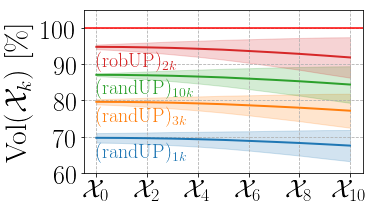

In [68]:
# Normalize in [%]
vol_true = 100.
vols_randUP = []
for m_id in range(len(M_vec)):
    vols_randUP.append(100*vols_randUP_ratios[m_id])
vols_robUP_percent = 100. * vols_robUP_ratios

from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5, 3))

truth_str = r'True'
plt.axhline(y=vol_true, color='r')#, label=truth_str)

# ----------------------------
# (randUP)
for m_id, M in enumerate(M_vec):
    label_str = r'(randUP)${}_{' + str(int(M/1e3))+'k}$'
    mean_vols_randUP =       np.mean(vols_randUP[m_id], 0)
    vars_vols_randUP = np.sqrt(np.var(vols_randUP[m_id], axis=0) )
    plt.plot(np.arange(T+1), mean_vols_randUP,         'C'+str(m_id), linewidth=2)#, label=label_str)
    plt.fill_between(np.arange(T+1), mean_vols_randUP-2.*vars_vols_randUP, mean_vols_randUP+2.*vars_vols_randUP, 
                                         color='C'+str(m_id), alpha=0.2)
    plt.text(0, mean_vols_randUP[0]-6, label_str, color='C'+str(m_id), fontsize=20, fontweight='bold')

# ----------------------------
# (robUP!)
label_str = r'(robUP)${}_{' + str(int(M_robUP/1e3))+'k}$'
mean_vols_robUP =        np.mean(vols_robUP_percent, 0)
vars_vols_robUP = np.sqrt(np.var(vols_robUP_percent, axis=0) )
plt.plot(np.arange(T+1), mean_vols_robUP,         'C3', linewidth=2)#, label=label_str)
plt.fill_between(np.arange(T+1), mean_vols_robUP-2.*vars_vols_robUP, mean_vols_robUP+2.*vars_vols_robUP, 
                                     color='C3', alpha=0.2)
plt.text(0, mean_vols_robUP[0]-6, label_str, color='C3', fontsize=20, fontweight='bold')
# ----------------------------


rc('text', usetex=True)

ax.tick_params("both", labelsize=26) 

labels_X = []
for i in range(0,T+1,2):
    labels_X.append(r'$\mathcal{X}_{' + str(i) + '}$')
plt.xticks(np.arange(0,T+1,2), (labels_X))

plt.yticks([60,70,80,90,100])

plt.ylim([60,105])

ax.set_ylabel(r'Vol($\mathcal{X}_k$) [\%]', rotation="vertical",fontsize=30)#, labelpad=24)

plt.grid(True, which='both', linestyle='--')

plt.savefig('data/nn_lip_comp/randUP_robUP_lip_X.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Only positions

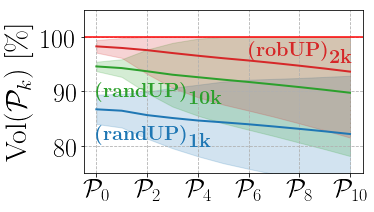

In [72]:
# Normalize in [%]
vol_pos_true = 100.
vols_pos_randUP = []
for m_id in range(len(M_vec)):
    vols_pos_randUP.append(100*vols_pos_randUP_ratios[m_id])
vols_pos_robUP_percent = 100. * vols_pos_robUP_ratios

from matplotlib import rc
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5, 3))

truth_str = r'True'
plt.axhline(y=vol_pos_true, color='r')#, label=truth_str)

# ----------------------------
# (randUP)
for m_id, M in enumerate(M_vec):
    if m_id==1: 
        continue
    label_str = r'\textbf{(randUP)}${}_{\textbf{' + str(int(M/1e3))+'k}}$'
    mean_vols_pos_randUP =       np.mean(vols_pos_randUP[m_id], 0)
    vars_vols_pos_randUP = np.sqrt(np.var(vols_pos_randUP[m_id], axis=0) )
    plt.plot(np.arange(T+1), mean_vols_pos_randUP,         'C'+str(m_id), linewidth=2)#, label=label_str)
    plt.fill_between(np.arange(T+1), mean_vols_pos_randUP-2.*vars_vols_pos_randUP, 
                                     np.minimum(mean_vols_pos_randUP+2.*vars_vols_pos_randUP, 100.), 
                                         color='C'+str(m_id), alpha=0.2)
    plt.text(0, mean_vols_pos_randUP[0]-7, label_str, color='C'+str(m_id), fontsize=20, fontweight='bold')

# ----------------------------
# (robUP!)
label_str = r'\textbf{(robUP)}${}_{\textbf{' + str(int(M_robUP/1e3))+'k}}$'
mean_vols_pos_robUP =        np.mean(vols_pos_robUP_percent, 0)
vars_vols_pos_robUP = np.sqrt(np.var(vols_pos_robUP_percent, axis=0) )
plt.plot(np.arange(T+1), mean_vols_pos_robUP,         'C3', linewidth=2)#, label=label_str)
plt.fill_between(np.arange(T+1), mean_vols_pos_robUP-2.*vars_vols_pos_robUP, 
                                 np.minimum(mean_vols_pos_robUP+2.*vars_vols_pos_robUP, 100.), 
                                     color='C3', alpha=0.2)
plt.text(6., mean_vols_pos_robUP[0]-3, label_str, color='C3', fontweight='bold', fontsize=20)
# ----------------------------


rc('text', usetex=True)

ax.tick_params("both", labelsize=26) 

labels_X = []
for i in range(0,T+1,2):
    labels_X.append(r'$\mathcal{P}_{' + str(i) + '}$')
plt.xticks(np.arange(0,T+1,2), (labels_X))

plt.yticks([80,90,100])

plt.ylim([75,105])

ax.set_ylabel(r'Vol($\mathcal{P}_k$) [\%]', rotation="vertical",fontsize=30)#, labelpad=24)

plt.grid(True, which='both', linestyle='--')

plt.savefig('data/nn_lip_comp/randUP_robUP_lip_P.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

### Plot

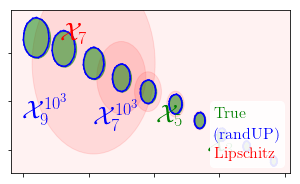

In [13]:
i = 0

idx = [0,1]
# idx = [2,3]

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(5, 3))
from matplotlib.ticker import NullFormatter
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

# -----------------------------
# Lipschitz
for t in range(T-1):
    mu_k, Q_k =  Xs_lip[i,t,:], Qs_lip[i,t,:,:] 
    if t < T-2:
        plot_ellipse(ax, mu_k[idx], Q_k[np.ix_(idx,idx)], color='r', alpha=0.1)
    if t == T-2:
        plot_ellipse(ax, mu_k[idx], Q_k[np.ix_(idx,idx)], color='r', alpha=0.05)
#     if t==4:
#         plt.text(mu_k[idx[0]]-0.6, mu_k[idx[1]]+0.05, r'$\mathcal{X}_{' + str(t) + '}$', 
#                  color='r', fontsize=26, fontweight='bold')
#     if t==5:
#         plt.text(mu_k[idx[0]]-0.3, mu_k[idx[1]]+2, r'$\mathcal{X}_{' + str(t) + '}$', 
#                  color='r', fontsize=26, fontweight='bold')
    if t==7:
        plt.text(mu_k[idx[0]]-1, mu_k[idx[1]]+.4, r'$\mathcal{X}_{' + str(t) + '}$', 
                 color='r', fontsize=26, fontweight='bold')
# -----------------------------

# -----------------------------
# true system
Xs_i_true, Qs_i_true = Xs_true[i,:,:], Qs_true[i,:,:,:]
for t in range(T):
    mu_k, Q_k =  Xs_i_true[t,:], Qs_i_true[t,:,:] 
    plot_ellipse(ax, mu_k[idx], Q_k[np.ix_(idx,idx)], color='g', alpha=0.5)
    if t>2 and t<6 and t!=4:
        plt.text(mu_k[idx[0]]+0.25, mu_k[idx[1]]-0.7, r'$\mathcal{X}_{' + str(t) + '}$', 
                 color='g', fontsize=26, fontweight='bold')
# -----------------------------
    
# -----------------------------
# (randUP)
Xs_i_randUP = Xs_randUP[i,:,:,:]
for t in range(T):
    hull = ConvexHull(Xs_i_randUP[:,t,idx])
    for simplex in hull.simplices:
        plt.plot(Xs_i_randUP[simplex,t,idx[0]], Xs_i_randUP[simplex,t,idx[1]], 'b-')
    if t==7:
        mu_k = np.mean(Xs_i_randUP[:,t,:], 0)
        plt.text(mu_k[idx[0]]-0., mu_k[idx[1]]-1.4, 
                 r'$\mathcal{X}_{' + str(t) + '}^{'+str(int(Xs_i_randUP.shape[0]/1e3))+'^3}$', 
                 color='b', fontsize=26, fontweight='bold')
    if t==9:
        mu_k = np.mean(Xs_i_randUP[:,t,:], 0)
        plt.text(mu_k[idx[0]]-0.4, mu_k[idx[1]]-1.8, 
                 r'$\mathcal{X}_{' + str(t) + '}^{'+str(int(Xs_i_randUP.shape[0]/1e3))+'^3}$', 
                 color='b', fontsize=26, fontweight='bold')
# -----------------------------

# -----------------------------
# (robUP)
# Xs_i_robUP = Xs_robUP[i,:,:,:]
# for t in range(T):
# #     plt.scatter(Xs_i_rUP[:,t,idx[0]], Xs_i_rUP[:,t,idx[1]], color='b', alpha=0.1)
#     hull = ConvexHull(Xs_i_robUP[:,t,idx])
#     for simplex in hull.simplices:
#         plt.plot(Xs_i_robUP[simplex,t,idx[0]], Xs_i_robUP[simplex,t,idx[1]], 'b-')
# -----------------------------

# add manual legend
from pylab import *
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
texts = ['True','(randUP)','Lipschitz']
colors = ['green','blue','red']
Texts = []
for t,c in zip(texts,colors):
    Texts.append(TextArea(t,textprops=dict(color=c,fontsize=16)))
texts_vbox = VPacker(children=Texts,pad=0,sep=3)
ann = AnnotationBbox(texts_vbox,(.94,.1),
                            xycoords=ax.transAxes,
                            box_alignment=(0.9,.1),
                            bboxprops = dict(facecolor='white',boxstyle='round',color='white', alpha=0.9))
ann.set_figure(fig)
fig.artists.append(ann)
# -----------------------------
# plt.savefig('data/nn_lip_comp/lip_comparison')

### Compare randUP and robUP visually

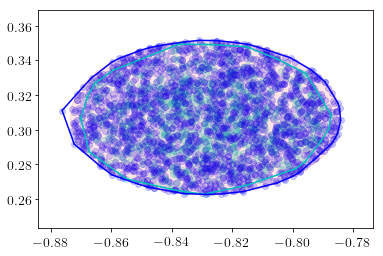

In [14]:
i, k = 0, 0
# idx = [0,1]
idx = [2,3]

# randUP
Xs_randUP = Xs_randUP_all[0]
plt.scatter(Xs_randUP[i,:,k,idx[0]],Xs_randUP[i,:,k,idx[1]],         color='c', alpha=0.2)
hull = ConvexHull(Xs_randUP[i,:,k,idx].T)
for simplex in hull.simplices:
    plt.plot(Xs_randUP[i,simplex,k,idx[0]], Xs_randUP[i,simplex,k,idx[1]], 'c-', alpha=1)
    
# robUP!
plt.scatter(Xs_robUP[i,:,k,idx[0]],Xs_robUP[i,:,k,idx[1]],             color='b', alpha=0.2)
hull = ConvexHull(Xs_robUP[i,:,k,idx].T)
for simplex in hull.simplices:
    plt.plot(Xs_robUP[i,simplex,k,idx[0]], Xs_robUP[i,simplex,k,idx[1]], 'b-', alpha=1)

# true ellipsoid
ax = plt.gca()
mu_k, Q_k =  Xs_true[i,k,idx], Qs_true[i,k,:,:] 
plot_ellipse(ax, mu_k, Q_k[np.ix_(idx,idx)], color='r', alpha=0.1)